
# **Лабораторная работа №5**

## Загрузка данных

---

В качестве набора данных будем использовать [набор данных о хоралах Баха](https://rpubs.com/bsnacks000/107391)

Набор данных содержит следующие колонки:
+ chorale_ID - номер хорала
+ event_number - id события
+ pitch_1 - pitch_12 - наличие в аккорде каждой из 12 нот
+ bass - нижняя нота аккорда
+ meter - важность аккорда
+ chord_label - название аккорда

In [98]:
!pip install -U heamy

from google.colab import drive
drive.mount('/content/drive')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [99]:
# Импорт библиотек
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
sns.set(style="ticks")

from typing import Dict
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from heamy.estimator import Classifier
from heamy.pipeline import ModelsPipeline
from heamy.dataset import Dataset

# Загрузка датасета
dataset = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/datasets/bach_choral_set_dataset.csv')

In [100]:
# Первые 5 строк датасета
dataset.head()

,choral_ID,event_number,pitch_1,pitch_2,pitch_3,pitch_4,pitch_5,pitch_6,pitch_7,pitch_8,pitch_9,pitch_10,pitch_11,pitch_12,bass,meter,chord_label
0,000106b_,1,YES,NO,NO,NO,NO,YES,NO,NO,NO,YES,NO,NO,F,3,F_M
1,000106b_,2,YES,NO,NO,NO,YES,NO,NO,YES,NO,NO,NO,NO,E,5,C_M
2,000106b_,3,YES,NO,NO,NO,YES,NO,NO,YES,NO,NO,NO,NO,E,2,C_M
3,000106b_,4,YES,NO,NO,NO,NO,YES,NO,NO,NO,YES,NO,NO,F,3,F_M
4,000106b_,5,YES,NO,NO,NO,NO,YES,NO,NO,NO,YES,NO,NO,F,2,F_M


In [101]:
# Будем использовать только два наиболее часто встречающихся класса
freqs = dataset['chord_label'].value_counts(normalize=True)*100
sfreqs = sorted(freqs)

ind = []
for i in range(0, dataset.shape[0]):
  if (freqs[dataset.iloc[i]['chord_label']]!=sfreqs[-1]) and (freqs[dataset.iloc[i]['chord_label']]!=sfreqs[-2]):
    ind.append(i)
dataset.drop(axis=0, index=ind, inplace = True)
dataset.shape

(992, 17)

In [102]:
# Кодирование категориальных признаков
le = LabelEncoder()
dataset['choral_ID'] = le.fit_transform(dataset['choral_ID'])
for i in range(1,13):
  col = 'pitch_'+str(i)
  dataset[col] = le.fit_transform(dataset[col])
dataset['bass'] = le.fit_transform(dataset['bass'])
dataset['chord_label'] = le.fit_transform(dataset['chord_label'])

In [103]:
# Разделение данных на целевые и нецелвые колонки
data = pd.DataFrame(dataset[dataset.columns.difference(['chord_label'])])
target = dataset['chord_label'].copy()

## Разделение на обучающую и тестовую выборки


---

In [104]:
# Разделение на обучающую и тестовую выборки
xtrain, xtest, ytrain, ytest = train_test_split(
    data, target, test_size=0.3, random_state=1)

train_acc = dict()
test_acc = dict()
gen_acc = dict()

In [105]:
def accuracy_score_for_classes(
    y_true: np.ndarray, 
    y_pred: np.ndarray) -> Dict[int, float]:
    """
    Вычисление метрики accuracy для каждого класса
    y_true - истинные значения классов
    y_pred - предсказанные значения классов
    Возвращает словарь: ключ - метка класса, 
    значение - Accuracy для данного класса
    """
    # Для удобства фильтрации сформируем Pandas DataFrame 
    d = {'t': y_true, 'p': y_pred}
    df = pd.DataFrame(data=d)
    # Метки классов
    classes = np.unique(y_true)
    # Результирующий словарь
    res = dict()
    # Перебор меток классов
    for c in classes:
        # отфильтруем данные, которые соответствуют 
        # текущей метке класса в истинных значениях
        temp_data_flt = df[df['t']==c]
        # расчет accuracy для заданной метки класса
        temp_acc = accuracy_score(
            temp_data_flt['t'].values, 
            temp_data_flt['p'].values)
        # сохранение результата в словарь
        res[c] = temp_acc
    return res

def print_acc(model, ytrain, ytrain_pred, ytest, ytest_pred):
  print('Train accuracy: ')
  for i in train_acc[model]:
    print(i,': ', train_acc[model][i])
  print('General: ', accuracy_score(ytrain, ytrain_pred))
  print('\nTest accuracy: ')
  for i in test_acc[model]:
    print(i,': ', test_acc[model][i])
  print('General: ', gen_acc[model])
  return

## Обучение моделей


---

In [106]:
# Бэггинг
bc = BaggingClassifier(n_estimators=10, random_state=10)
bc.fit(xtrain, ytrain)

bc_train_pred = bc.predict(xtrain)
bc_test_pred = bc.predict(xtest)
train_acc['Bagging'] = accuracy_score_for_classes(ytrain, bc_train_pred)
test_acc['Bagging'] = accuracy_score_for_classes(ytest, bc_test_pred)
gen_acc['Bagging'] = accuracy_score(ytest, bc_test_pred)

print_acc('Bagging', ytrain, bc_train_pred, ytest, bc_test_pred)

Train accuracy: 
0 :  1.0
1 :  0.9971181556195965
General:  0.9985590778097982

Test accuracy: 
0 :  0.9230769230769231
1 :  0.9225352112676056
General:  0.9228187919463087


In [107]:
# Бустинг
ab = AdaBoostClassifier(n_estimators=10, algorithm='SAMME', random_state=10)
ab.fit(xtrain, ytrain)

ab_train_pred = ab.predict(xtrain)
ab_test_pred = ab.predict(xtest)
train_acc['AdaBoost'] = accuracy_score_for_classes(ytrain, ab_train_pred)
test_acc['AdaBoost'] = accuracy_score_for_classes(ytest, ab_test_pred)
gen_acc['AdaBoost'] = accuracy_score(ytest, ab_test_pred)

print_acc('AdaBoost', ytrain, ab_train_pred, ytest, ab_test_pred)

Train accuracy: 
0 :  0.9193083573487032
1 :  0.9798270893371758
General:  0.9495677233429395

Test accuracy: 
0 :  0.9294871794871795
1 :  0.9788732394366197
General:  0.9530201342281879


In [108]:
# Стекинг
# Набор данных
ds = Dataset(xtrain, ytrain, xtest, ytest)

# Модели первого уровня
model_tree = Classifier(dataset=ds, estimator=DecisionTreeClassifier, name='tree', probability=False)
model_rf = Classifier(dataset=ds, estimator=RandomForestClassifier, parameters={'n_estimators': 50}, name='rf', probability=False)

# Первый уровень - две модели: дерево и случайный лес 
pipeline = ModelsPipeline(model_tree, model_rf)
stack_ds = pipeline.stack(k=10, seed=1)

# Модель второго уровня - логистическая регрессия
stacker = Classifier(dataset=stack_ds, estimator=RandomForestClassifier, probability = False)
results = stacker.validate(k=10, scorer=accuracy_score)

Metric: accuracy_score
Folds accuracy: [0.9571428571428572, 0.9714285714285714, 0.9857142857142858, 0.9714285714285714, 0.9420289855072463, 0.9565217391304348, 1.0, 0.9130434782608695, 0.9855072463768116, 0.9855072463768116]
Mean accuracy: 0.9668322981366462
Standard Deviation: 0.02430024505326127
Variance: 0.0005905019096485488


In [109]:
gen_acc['Stacking'] = 0.9683022774327125

## Сравнение моделей


---

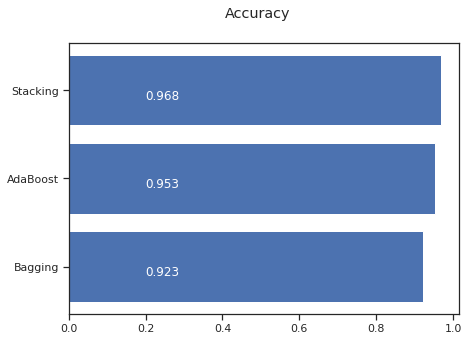

In [110]:
fig, ax = plt.subplots(figsize=(7,5))
fig.suptitle('Accuracy')
ind = np.arange(len(gen_acc))
plt.barh(ind, gen_acc.values())
plt.yticks(ind, gen_acc)
# Вывод значений
for a,b in zip(ind, gen_acc.values()):
        plt.text(0.2, a-0.1, str(round(b,3)), color='white')
plt.show()